In [1]:
%matplotlib inline

# Dynamic SAX tutorial
We assume there that you already know what is a SAX transformation. If you don't, please refer to our [section about it](https://timeseriesanalysis.github.io/static_sax.html) or on our [tutorial](https://timeseriesanalysis.github.io/static_sax_tutorial.html).
The aim of this tutorial is to show how works our algorithm on simple dynamic data first and then on dynamic EEG data.
The following examples are leaning on __incremental_SAX__ file in __script__ folder of our repository.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import norm
sys.path.append("..")
from script.dynamic_SAX import Dynamic_SAX
from bisect import insort_left as sinsert
from bisect import bisect_left as sindex

# DYNAMIC SAX ON SIMPLE DATA
We are going to use here the same non realistic data than in the static version's tutorial. Just to remind what they look like we will plot again our simple time series.

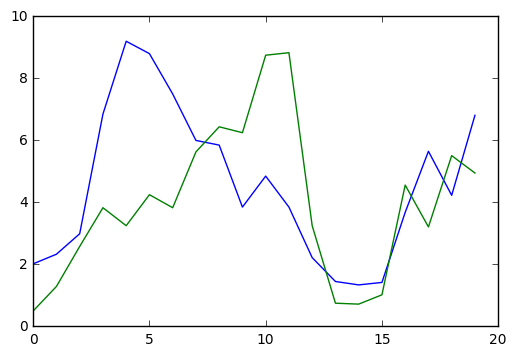

In [3]:
data1 = np.asarray([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34, 1.42, 3.68, 5.65, 4.23, 6.81])
data2 = np.asarray([0.50, 1.29, 2.58, 3.83, 3.25, 4.25, 3.83, 5.63, 6.44, 6.25, 8.75, 8.83, 3.25, 0.75, 0.72, 1.02, 4.56, 3.21, 5.51, 4.95])
time_series = np.asarray([data1,data2])
plt.plot(range(time_series.shape[1]),time_series[0,:])
plt.plot(range(time_series.shape[1]),time_series[1,:])

We are here choosing the same alphabet and the same parameters than in the other SAX tutorial. Just to compare the results given by this approach.
Let examine all the steps needed to initialize our algorithm.

In [4]:
alphabet = range(10)
alphabet_size = len(alphabet)
nb_interval = 10
length_interval = 2
window_size = nb_interval * length_interval
window = time_series[:,:window_size].T                                                
sorted_distribution = np.sort(window, axis = 0, kind = 'mergesort')
index_oldest = 0                                                                                     
global_mean = window.mean(axis = 0)                                          
global_variance = window.var(axis = 0)
percentils_index = map(lambda x : (int(x),x%1), [1.*i * (window_size - 1) / alphabet_size for i in xrange(1, alphabet_size)])

So what did we do so far ? 

Well, we stored our data, compute mean and var on a numpy array and compute percentils index.
As a matter of fact, instead of using the function _np.percentil_ each time we use a tip. Since percentils are just numbers belonging to the serie (or interpolated value between two values), we stored the current sorted current distribution to compute faster the percentils and take all the $i^e$ $\frac{window\_size - 1}{N}$ value as percentils.

We need here, to normalize data for the same reason mentioned in the previous tutorial but we need to apply it also to the sorted distribution to obtain proper percentils.

In [5]:
window = (window - global_mean) / np.sqrt(global_variance)
sorted_distribution  = (sorted_distribution - global_mean) / np.sqrt(global_variance)
percentils = [[(sorted_distribution[i + 1][k] * j + sorted_distribution[i][k] * (1 - j)) for i, j in percentils_index] for k in xrange(window.shape[1])]
subwin_means = np.asarray(map(lambda xs: xs.mean(axis = 0), np.vsplit(window, nb_interval)))
SAX = np.zeros(subwin_means.shape)
sorted_distribution = sorted_distribution.T.tolist()

Once normalized , we compute the percentils values. Our way to compute them handle more difficult cases such as when the indices are decimal. We simply weight each value around the exact computed index.
Once here, since we already have PAA transformed data, we just need to get SAX translation.

In [6]:
for i in xrange(SAX.shape[0]):
    for j in xrange(SAX.shape[1]):
        SAX[i][j] = alphabet[sindex(percentils[j],subwin_means[i][j])]

Here we are using python's *bisect_left* built-in function which returns the index of where to put *subwin_mean* in *percentils* in $O(\log(n))$. The index returned will correspond to the index of the chosen alphabet !

And guess what ? We finally have initialized our algorithm ! But to be honnest, the most costly part of the algorithm is here.

But what about the results ? Do we have an equivalent SAX if we compare to the first tutorial ?

In [7]:
print SAX

[[ 1.  1.]
 [ 5.  3.]
 [ 9.  4.]
 [ 7.  6.]
 [ 5.  8.]
 [ 5.  9.]
 [ 1.  2.]
 [ 0.  1.]
 [ 5.  5.]
 [ 6.  7.]]


What a relief ! We have exactly the same SAX transform here and in our other tutorial (the opposite would have been annoying).
Yes nothing brand new so far ... But let assume that you now receive a new point for each time serie and you must add them in your data. Instead of just adding the point to the already existing data and perform an other __Static SAX__ we will use some tips such as removing the oldest point. As a matter of fact, you can't imagine to store all the incoming data and especially on a long time serie for each captured data. 

Let assume that we want first add one point to each time serie simultaneously.

In [8]:
n_point = np.asarray([7.2, 3.8])

Naturally, the first step is to update global parameters i.e the mean value and variance of the sliding window, just as percentils of the new distribution.

In [9]:
print "former mean : ", global_mean
print "former variance : ", global_variance

former mean :  [ 4.5445  3.97  ]
former variance :  [ 5.73095475  5.83619   ]


In [10]:
new_point = (n_point - global_mean) * 1./ np.sqrt(global_variance)
removed_point = window[index_oldest]
temp_mean = global_mean
global_mean = temp_mean + (new_point - removed_point) * 1. * np.sqrt(global_variance) / window_size
global_variance = global_variance + (new_point**2 -removed_point**2 - 2*temp_mean*(new_point - removed_point) - (new_point - removed_point)**2 * 1. / window_size) *1. /window_size 

print "new mean : ", global_mean
print "new variance : ", global_variance
print "reality : ", (np.asarray([7.2, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34, 1.42, 3.68, 5.65, 4.23, 6.81]).std())**2

new mean :  [ 4.8035  4.135 ]
new variance :  [ 4.74183303  5.18631537]
reality :  5.69780275


In [25]:

a = np.asarray([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34, 1.42, 3.68, 5.65, 4.23, 6.81])
a_moy = a.mean()
a_var = a.var()
a_std = a.std()
a_norm = (a - a.mean())*1./a.std()
a_nmoy = a_norm.mean()
n = 7.2
n_norm = (n - a.mean())*1./a.std()
n_norm
temp = a[0]
temp_n = a_norm[0]
a[0] = n
a_norm[0] = n_norm
print a.mean()
print a_moy + (n - temp)*1./20
print a_moy + (n_norm - temp_n)*1.*a_std/20
print a.var()
print a_var + ((n_norm**2 - temp_n**2 + 2*a_moy*(-temp_n + n_norm))*a_var - 2*a_moy*(n_norm - temp_n)*a_std - ((n_norm - temp_n) * a_var)**2 * 1./20)*1./20

4.8035
4.8035
4.8035
5.69780275
8.66185438835
